# Train the Fully Connected Autoencoder

| **Dataset**      | **Encoder** | **orig_size** |
|------------------|-------------|---------------|
| TinyImagenet     | -           | 64x64x3       |
| TinyImagenet     | cutr3       | 4x4x256       |
|                  |             |               | 
|   CIFAR10        | -           | 32x32x3       |
|   CIFAR10        | cutr3       | 2x2x256       |

Note: this code is a little bit scrappy, so be careful when using it, especially with output-filenames!

In [10]:
import argparse
from pathlib import Path
import torch
import torchvision
from torchvision.datasets import CIFAR10
import pandas as pd
import plotly.express as px
from utils import seed_everything, AverageMeter, science_config_png, science_template   # type: ignore
from opts import parse_general_args, add_general_args
from encoders import get_encoder_arg_fn, get_encoder, EncoderInfo
from compressors import get_compressor_arg_fn
from compressors.conv_autoencoder import ConvAutoencoder
from backbones import get_backbone_arg_fn
from samplers import get_sampler_arg_fn
from datasets import ContinualDatasetInfo

CLI-Arguments

In [11]:
DATA_DIR = '/home/marwei/pytorch'
pretraining_classes = [0, 1]

args = [
    "--dataset", "TinyImagenet", # Does not matter
    "--num_classes_per_task", "20", # Does not matter
    "--num_tasks", "10",    # Does not matter
    "--seed", "0",
    "--memory_size", "10000", # Does not matter
    "--num_passes", "10",
    "--sampler", "greedy_sampler", # Does not matter
    "--encoder", "none",
    # "--encoder", "cutr_cifar",
    # "--encoding_block", "0",
    "--compressor", "convae",
    "--latent_channels", "32",
    "--backbone", "resnet", # Does not matter
    "--data_dir", DATA_DIR,
    "--exp_name", "test"
]

Set everything up

In [12]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
])


trainset_full = CIFAR10(
    train=True,
    transform=train_transforms,
    root=DATA_DIR,
    download=True
)
train_subset_idxs = [i for i in range(len(trainset_full)) if trainset_full.targets[i] in pretraining_classes]
trainset = torch.utils.data.Subset(trainset_full, train_subset_idxs)

testset_full = CIFAR10(
    train=False,
    transform=test_transforms,
    root=DATA_DIR,
    download=True
)
test_subset_idxs = [i for i in range(len(testset_full)) if testset_full.targets[i] in pretraining_classes]
testset = torch.utils.data.Subset(testset_full, test_subset_idxs)

train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    shuffle=True,
    batch_size=16,
    num_workers=4,
)
test_loader = torch.utils.data.DataLoader(
    dataset=testset,
    shuffle=False,
    batch_size=16,
    num_workers=4,
)

dataset_info = ContinualDatasetInfo(
    num_classes=2,
    channels=3,
    size=(32, 32)
)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
parse_general_args(args=args)

general_args = parse_general_args(args)

add_encoder_args = get_encoder_arg_fn(general_args.encoder)
add_backbone_args = get_backbone_arg_fn(general_args.backbone)
add_sampler_args = get_sampler_arg_fn(general_args.sampler)
add_compressor_args = get_compressor_arg_fn(general_args.compressor)

parser = argparse.ArgumentParser()
add_general_args(parser)
add_encoder_args(parser)
add_compressor_args(parser)
add_backbone_args(parser)
add_sampler_args(parser)
opt = parser.parse_args(args)

assert opt.compressor == 'fcae' or opt.compressor == 'convae', 'This Notebook is only for training the Autoencoder'

seed_everything(opt.seed)

encoder = get_encoder(opt, dataset_info).to(opt.device)
ae = ConvAutoencoder(opt, encoder.info(), train_ae=True).to(opt.device)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

In [14]:
print(ae.info())
print(encoder.info())

CompressorDecompressorInfo(in_size=(32, 32), in_channels=3, compressed_size=(8, 8), compressed_channels=16, out_size=(32, 32), out_channels=3)
EncoderInfo(in_size=(32, 32), in_channels=3, out_size=(32, 32), out_channels=3, name='passThrough')


In [15]:
def train(ae, encoder, optimizer, criterion, train_loader, epoch):
    ae.train()
    train_loss = AverageMeter()
    n_train = len(train_loader)
    for i, (unencoded, _) in enumerate(train_loader):
        unencoded = unencoded.to(opt.device)
        encoded = encoder(unencoded)

        optimizer.zero_grad()
        output = ae(encoded)
        
        loss = criterion(output, encoded)
        loss.backward()
        train_loss.update(loss.item())
        optimizer.step()

        if i % 500 == 0:
            print(f'epoch {epoch} \tdata {i}/{n_train} \ttrain \tloss: {train_loss.avg:.4f}')
    
    return ae, optimizer, train_loss


def test(ae, encoder, criterion, test_loader, epoch):
    ae.eval()
    test_loss = AverageMeter()
    n_test = len(test_loader)
    with torch.no_grad():
        for i, (unencoded, _) in enumerate(test_loader):
            unencoded = unencoded.to(opt.device)
            encoded = encoder(unencoded)
            output = ae(encoded)
            test_loss.update(criterion(output, encoded).item())
            if i % 100 == 0:
                print(f'epoch {epoch} \tdata {i}/{n_test} \ttest \tloss: {test_loss.avg:.4f}')
    return test_loss

aaand go!

In [16]:
param_filename = f'autoencoder_cifar10_classe01_{encoder.info().name}_lc_{opt.latent_channels}.pt'
param_file = Path('compressors', 'compressor_params', param_filename).resolve()

assert not param_file.exists(), 'File exists, delete this assertion to continue!'

first_test_loss = test(
    ae=ae,
    encoder=encoder,
    criterion=criterion,
    test_loader=test_loader,
    epoch=0
)
test_losses = [(-1, first_test_loss.avg)]
train_losses = []

for epoch in range(opt.num_passes):
    
    ae, optimizer, train_loss = train(
        ae=ae,
        encoder=encoder,
        optimizer=optimizer,
        criterion=criterion,
        train_loader=train_loader,
        epoch=epoch+1
    )
            
    test_loss = test(
        ae=ae,
        encoder=encoder,
        criterion=criterion,
        test_loader=test_loader,
        epoch=epoch+1
    )

    train_losses.append((epoch, train_loss.avg))
    test_losses.append((epoch, test_loss.avg))
    
# save the model
torch.save(ae.state_dict(), param_file)
print('saved :)')

epoch 0 	data 0/125 	test 	loss: 2.0506
epoch 0 	data 100/125 	test 	loss: 1.7920
epoch 1 	data 0/625 	train 	loss: 1.6908
epoch 1 	data 500/625 	train 	loss: 0.4290
epoch 1 	data 0/125 	test 	loss: 0.2077
epoch 1 	data 100/125 	test 	loss: 0.1954
epoch 2 	data 0/625 	train 	loss: 0.1932
epoch 2 	data 500/625 	train 	loss: 0.1787
epoch 2 	data 0/125 	test 	loss: 0.1561
epoch 2 	data 100/125 	test 	loss: 0.1539
epoch 3 	data 0/625 	train 	loss: 0.1710
epoch 3 	data 500/625 	train 	loss: 0.1476
epoch 3 	data 0/125 	test 	loss: 0.1427
epoch 3 	data 100/125 	test 	loss: 0.1413
epoch 4 	data 0/625 	train 	loss: 0.1417
epoch 4 	data 500/625 	train 	loss: 0.1367
epoch 4 	data 0/125 	test 	loss: 0.1346
epoch 4 	data 100/125 	test 	loss: 0.1320
epoch 5 	data 0/625 	train 	loss: 0.1320
epoch 5 	data 500/625 	train 	loss: 0.1287
epoch 5 	data 0/125 	test 	loss: 0.1278
epoch 5 	data 100/125 	test 	loss: 0.1243
epoch 6 	data 0/625 	train 	loss: 0.1211
epoch 6 	data 500/625 	train 	loss: 0.1225
epoc

In [17]:
learning_curve_test = pd.DataFrame(test_losses, columns=['epoch', 'test_loss'])
learning_curve_train = pd.DataFrame(train_losses, columns=['epoch', 'train_loss'])
learning_curve_merged = pd.merge(left=learning_curve_test, how='outer', right=learning_curve_train, left_on='epoch', right_on='epoch')
learning_curve_merged.epoch = learning_curve_merged.epoch + 1
fig = px.line(
    learning_curve_merged,
    x='epoch',
    y=['train_loss', 'test_loss'],
    title=f'Learning Curve for {opt.latent_channels}, {opt.encoder}',
    log_y=True,
    labels={
        'epoch': 'Epoch',
        'value': 'Loss',
        'train_loss': 'Train',
        'test_loss': 'Test',
    },
    template=science_template
)
fig.show(renderer='browser', config=science_config_png)
# fig.write_html(param_filename + '.html')

Show some Images


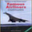
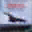
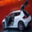
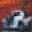
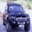
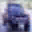
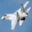
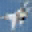
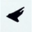
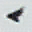

In [18]:
imgs = [testset[i][0].to(opt.device) for i in range(5)]
to_img = lambda x: ((x.permute([1, 2, 0]) -  x.min()) / (x.max()-x.min()) * 255).detach().to('cpu').numpy()

from plotly.subplots import make_subplots
fig = make_subplots(rows=5, cols=2)
for this_row in range(5):
    fig.add_trace(px.imshow(to_img(imgs[this_row])).data[0], row=this_row+1, col=1)
    fig.add_trace(px.imshow(to_img(ae(imgs[this_row]))).data[0], row=this_row+1, col=2)
fig.update_layout(height=1000)
fig.show()